<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melting_research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Snow Melting Prediction With LSTM, TCN and Transformer**

## install required library

In [119]:
# !pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

## import Library

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
# import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Dataset

In [269]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


## Dataset Pre-processing

In [270]:
features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [271]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [272]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-272-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T
0,2001-01-01,2.69,345.815123,-4.169740
1,2001-01-02,2.53,343.608727,-4.142604
2,2001-01-03,2.53,341.437417,-5.148725
3,2001-01-04,2.43,339.336277,-6.523695
4,2001-01-05,2.53,337.340394,-6.860106
...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230
4013,2012-12-27,2.91,219.264614,-5.501225
4014,2012-12-28,3.03,210.043412,-5.526874
4015,2012-12-29,2.97,201.080703,-5.107484


## Data visualization in time series

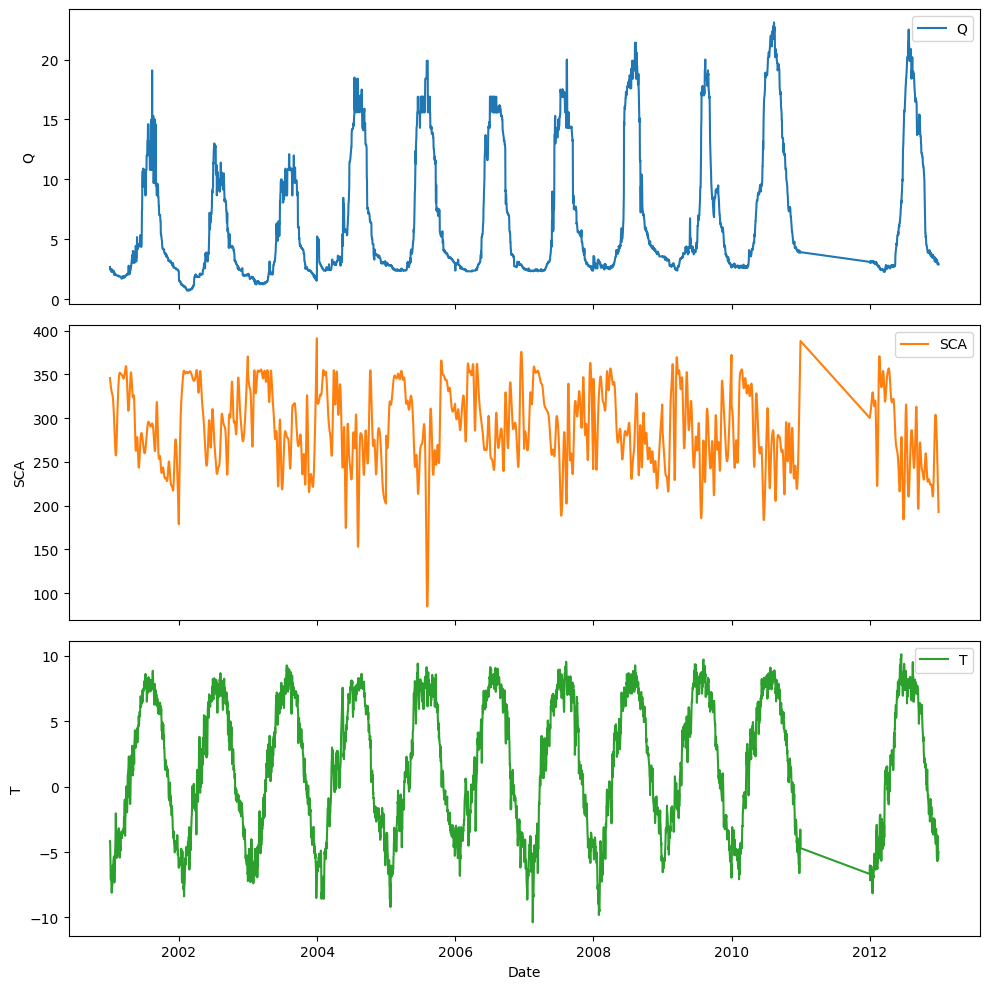

In [273]:
columns_to_plot = ['Q', 'SCA', 'T']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [274]:
df_input = df_snow_melting[['Q','SCA', 'T']]


scaler = MinMaxScaler()

# Select the features you want to scale
features_to_scale = ['Q', 'SCA', 'T']

# Fit the scaler to the data and transform the selected features
df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


<ipython-input-274-87c1da93d2bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [275]:
df_input

,Q,SCA,T
0,0.087577,0.851791,0.302737
1,0.080424,0.844592,0.304062
2,0.080424,0.837508,0.254949
3,0.075953,0.830653,0.187831
4,0.080424,0.824141,0.171409
...,...,...,...
4012,0.097412,0.469406,0.230419
4013,0.097412,0.438898,0.237742
4014,0.102776,0.408812,0.236490
4015,0.100094,0.379570,0.256962


In [276]:
#[[[1],[2],[3],[4],[5]]][6]
#[[[2],[3],[4],[5],[6]]][7]
#[[[3],[4],[5],[6],[7]]][8]

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [277]:
X_train, y_train = X[:3285],y[:3285] # 9 year 80%
X_val, y_val = X[3285:3648],y[3285:3648] # 363 days 10%
X_test, y_test = X[3648:],y[3648:]  # 364 day 10%


In [278]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((3285, 2, 3), (3285,), (363, 2, 3), (363,), (367, 2, 3), (367,))

In [279]:
num_features =  X_train.shape[2]


In [247]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=False, input_shape=(WINDOW_SIZE, num_features)))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
optimizer = Adamax(learning_rate=0.002,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae',RootMeanSquaredError()])


In [248]:
cp = ModelCheckpoint('model_64_layer_1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,callbacks=[cp])


Epoch 1/100
103/103 [==============================] - 4s 26ms/step - loss: 0.0180 - mae: 0.0933 - root_mean_squared_error: 0.1341 - val_loss: 0.0059 - val_mae: 0.0585 - val_root_mean_squared_error: 0.0768
Epoch 2/100
103/103 [==============================] - 4s 35ms/step - loss: 0.0031 - mae: 0.0421 - root_mean_squared_error: 0.0558 - val_loss: 0.0018 - val_mae: 0.0333 - val_root_mean_squared_error: 0.0423
Epoch 3/100
103/103 [==============================] - 3s 27ms/step - loss: 0.0024 - mae: 0.0354 - root_mean_squared_error: 0.0485 - val_loss: 0.0010 - val_mae: 0.0247 - val_root_mean_squared_error: 0.0317
Epoch 4/100
103/103 [==============================] - 1s 5ms/step - loss: 0.0019 - mae: 0.0305 - root_mean_squared_error: 0.0433 - val_loss: 0.0013 - val_mae: 0.0276 - val_root_mean_squared_error: 0.0359
Epoch 5/100
103/103 [==============================] - 2s 23ms/step - loss: 0.0018 - mae: 0.0292 - root_mean_squared_error: 0.0420 - val_loss: 8.5231e-04 - val_mae: 0.0217 - val

In [301]:
from tensorflow.keras.models import load_model

model = load_model('model_tensformer/')

# Model Evaulation

103/103 [==============================] - 1s 7ms/step
MAE: 0.09477865862219635
RMSE: 0.1197758572139898
R-squared (R2): 0.7149037582107912


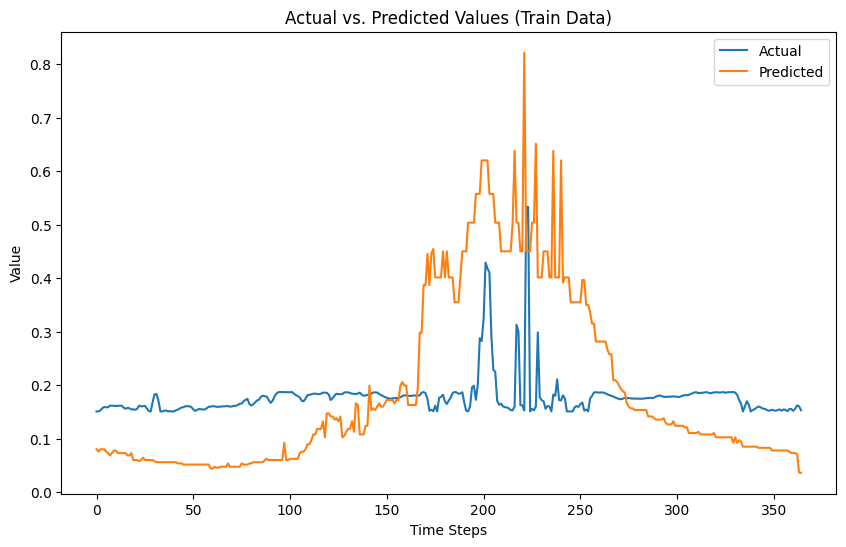

In [303]:

train_predictions = model.predict(X_train).flatten()
# train_predictions.shape
train_result = pd.DataFrame(data={"Train Predictions":train_predictions,"Actuals":y_train})
# Calculate MAE
mae = mean_absolute_error(y_train, train_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate R2
r2 = r2_score(y_train, train_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)



plt.figure(figsize=(10, 6))
plt.plot(train_result['Train Predictions'][0:365], label='Actual')
plt.plot(train_result['Actuals'][0:365], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Train Data)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 5ms/step
MAE: 0.11013540297129568
RMSE: 0.13503236110474148
R-squared (R2): 0.8070452263867937


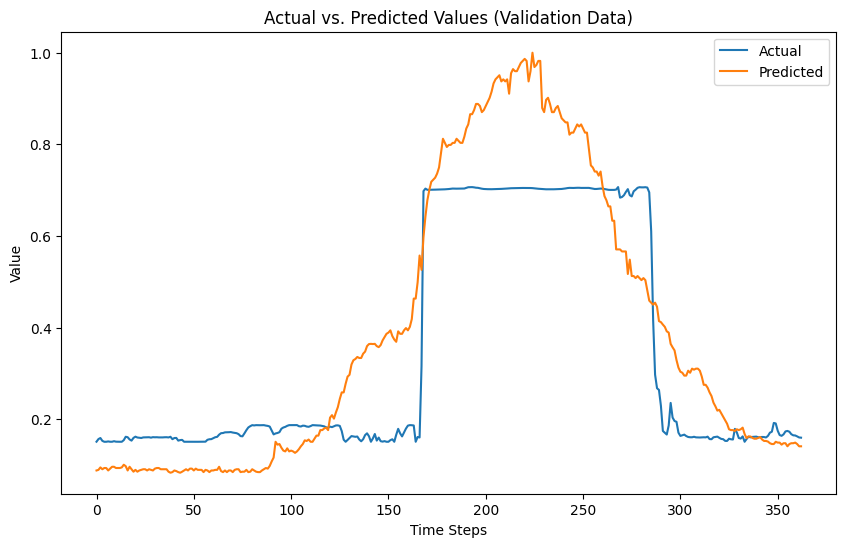

In [304]:
val_predictions = model.predict(X_val).flatten()


# Calculate MAE
mae = mean_absolute_error(y_val, val_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R2
r2 = r2_score(y_val, val_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


val_result = pd.DataFrame(data={"val Predictions":val_predictions,"Actuals":y_val})


plt.figure(figsize=(10, 6))
plt.plot(val_result['val Predictions'], label='Actual')
plt.plot(val_result['Actuals'], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

12/12 [==============================] - 0s 6ms/step
MAE: 0.0836398569756898
RMSE: 0.10306891842243389
R-squared (R2): 0.8655922335283529


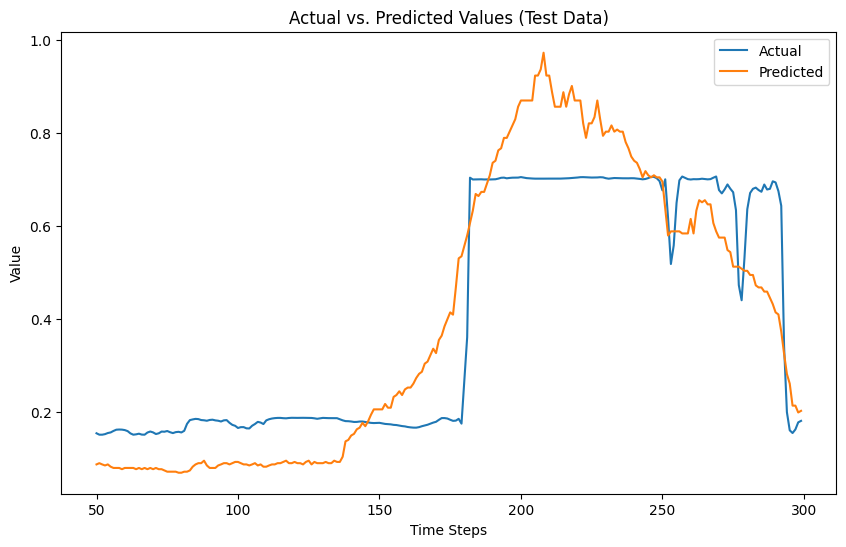

In [305]:
test_predictions = model.predict(X_test).flatten()

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})

plt.figure(figsize=(10, 6))
plt.plot(test_result['test Predictions'][50:300], label='Actual')
plt.plot(test_result['Actuals'][50:300], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()

# Hyperparameter Tuning

# find optimizers

In [158]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(6,3)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [159]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=10)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 6 Complete [00h 00m 08s]
val_loss: 1.6287680864334106

Best val_loss So Far: 1.3862440586090088
Total elapsed time: 00h 01m 02s


In [ ]:
tuner.get_best_hyperparameters()[0].values


{'optimizer': 'sgd'}

In [ ]:
!rm -r /content/untitled_project

## Number of hidden units

In [ ]:
def build_model(hp):
    model = Sequential()

    units = hp.Int('units',min_value = 1,max_value = 128,step=5)

    model.add(LSTM(units=units, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 05s]
val_mae: 6.208195686340332

Best val_mae So Far: 1.8050360679626465
Total elapsed time: 00h 09m 47s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'units': 36, 'optimizer': 'sgd'}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 9.0709 - mae: 2.0290 - mse: 9.0709 - val_loss: 7.1922 - val_mae: 1.8182 - val_mse: 7.1922
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.8137 - mae: 2.0119 - mse: 8.8137 - val_

# learning rate

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(LSTM(36, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=hp.Float(name='lr', min_value=0.005, max_value=0.05, step=0.005),momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 89 Complete [00h 00m 05s]
val_mae: 1.743226170539856

Best val_mae So Far: 1.7157219648361206
Total elapsed time: 00h 07m 58s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'lr': 0.034999999999999996, 'mom': 0.5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 3s 7ms/step - loss: 8.6616 - mae: 1.9773 - mse: 8.6616 - val_loss: 6.9002 - val_mae: 1.7289 - val_mse: 6.9002
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.7430 - mae: 1.9854 - mse: 8.7430 - val_

#number of layers

In [ ]:
def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers',min_value=1,max_value=5)):
      model.add(LSTM(36, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=0.034999999999999996,momentum=0.5)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 5 Complete [00h 00m 06s]
val_mae: 4.357283115386963

Best val_mae So Far: 4.258514881134033
Total elapsed time: 00h 00m 56s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 36)             5472      
                                                                 
 lstm_1 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_2 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_3 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_4 (LSTM)               (None, 2, 36)             10512     
                                                                 
 dropout (Dropout)           (None, 2, 36)             0         
                                                                 
 dense (Dense)               (None, 2, 1)              3

In [124]:
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    units = [hp.Int('units_' + str(i), min_value=32, max_value=128, step=32) for i in range(num_layers)]
    activations = [hp.Choice('activation_' + str(i), values=['relu', 'tanh']) for i in range(num_layers)]

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Set return_sequences to True for all but the last layer
        model.add(LSTM(units[i], activation=activations[i], return_sequences=return_sequences, input_shape=(6, 3)))

    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values=["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax"])

    # Set the learning rate based on the optimizer choice
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [125]:
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=100,
                         directory="final_dir",
                         project_name = "snow_melt_research_work")

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 26s]
val_loss: 11.89901065826416

Best val_loss So Far: 3.8367700576782227
Total elapsed time: 00h 34m 00s


In [126]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units_0': 64,
 'activation_0': 'relu',
 'optimizer': 'rmsprop',
 'learning_rate': 0.0005118355272157859,
 'units_1': 96,
 'activation_1': 'relu',
 'units_2': 32,
 'activation_2': 'relu'}

In [127]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 6, 96)             61824     
                                                                 
 lstm_2 (LSTM)               (None, 32)                16512     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 95777 (374.13 KB)
Trainable params: 95777 (374.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [128]:
cp = ModelCheckpoint('model1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,callbacks=[cp,early_stopping])

Epoch 1/100
103/103 [==============================] - 13s 80ms/step - loss: 6.8771 - mae: 1.7574 - mse: 6.8771 - val_loss: 7.5383 - val_mae: 1.9378 - val_mse: 7.5383
Epoch 2/100
103/103 [==============================] - 2s 22ms/step - loss: 6.7073 - mae: 1.7309 - mse: 6.7073 - val_loss: 10.4346 - val_mae: 2.2795 - val_mse: 10.4346
Epoch 3/100
103/103 [==============================] - 2s 19ms/step - loss: 6.1898 - mae: 1.6495 - mse: 6.1898 - val_loss: 9.6750 - val_mae: 2.2440 - val_mse: 9.6750
Epoch 4/100
103/103 [==============================] - 6s 60ms/step - loss: 6.2918 - mae: 1.6585 - mse: 6.2918 - val_loss: 6.0568 - val_mae: 1.7667 - val_mse: 6.0568
Epoch 5/100
103/103 [==============================] - 3s 29ms/step - loss: 6.0807 - mae: 1.6237 - mse: 6.0807 - val_loss: 6.7698 - val_mae: 1.9308 - val_mse: 6.7698
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 5.8155 - mae: 1.5951 - mse: 5.8155 - val_loss: 6.7678 - val_mae: 1.9000 - val_mse: 6.7678
E

# Transformer

In [299]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the Transformer model
def build_transformer_model(input_shape, num_heads, ff_dim, num_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.layers.Input(shape=input_shape)

    x = inputs
    for _ in range(num_blocks):
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=1, dropout=dropout
        )(x, x)
        res = x
        x = layers.LayerNormalization()(x)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = layers.Dense(input_shape[-1])(x)
        x = layers.Dropout(mlp_dropout)(x)
        x = layers.Add()([res, x])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(input_shape[-1])(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

# Define model hyperparameters
input_shape = (WINDOW_SIZE, num_features)  # Adjust input shape accordingly
num_heads = 2
ff_dim = 8
num_blocks = 2
mlp_units = 64
dropout = 0.1
mlp_dropout = 0.1

# Build the model
model = build_transformer_model(
    input_shape,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_blocks=num_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae',RootMeanSquaredError()])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 2, 3)]               0         []                            
                                                                                                  
 multi_head_attention_14 (M  (None, 2, 3)                 33        ['input_8[0][0]',             
 ultiHeadAttention)                                                  'input_8[0][0]']             
                                                                                                  
 layer_normalization_28 (La  (None, 2, 3)                 6         ['multi_head_attention_14[0][0
 yerNormalization)                                                  ]']                           
                                                                                            

In [300]:
cp = ModelCheckpoint('model_tensformer/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
103/103 [==============================] - 11s 53ms/step - loss: 0.5828 - mae: 0.7148 - root_mean_squared_error: 0.7634 - val_loss: 0.3427 - val_mae: 0.5671 - val_root_mean_squared_error: 0.5854
Epoch 2/10
103/103 [==============================] - 44s 430ms/step - loss: 0.1601 - mae: 0.3381 - root_mean_squared_error: 0.4002 - val_loss: 0.0624 - val_mae: 0.2140 - val_root_mean_squared_error: 0.2497
Epoch 3/10
103/103 [==============================] - 6s 60ms/step - loss: 0.0596 - mae: 0.1864 - root_mean_squared_error: 0.2441 - val_loss: 0.0264 - val_mae: 0.1258 - val_root_mean_squared_error: 0.1623
Epoch 4/10
103/103 [==============================] - 5s 47ms/step - loss: 0.0465 - mae: 0.1643 - root_mean_squared_error: 0.2157 - val_loss: 0.0219 - val_mae: 0.1186 - val_root_mean_squared_error: 0.1481
Epoch 5/10
103/103 [==============================] - 6s 55ms/step - loss: 0.0412 - mae: 0.1547 - root_mean_squared_error: 0.2029 - val_loss: 0.0210 - val_mae: 0.1174 - val_root